# 9.12 实战Kaggle比赛：图像分类（CIFAR-10）

我们曾在“图像增广”一节中实验过CIFAR-10数据集。它是计算机视觉领域的一个重要数据集。现在我们将应用前面所学的知识，动手实战CIFAR-10图像分类问题的Kaggle比赛。该比赛的网页地址是 https://www.kaggle.com/c/cifar-10 。

图9.16展示了该比赛的网页信息。为了便于提交结果，请先在Kaggle网站上注册账号。

![alt text](https://zh.d2l.ai/_images/kaggle_cifar10.png)

In [0]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

## 9.12.1. 获取和整理数据集

比赛数据分为训练集和测试集。训练集包含5万张图像。测试集包含30万张图像，其中有1万张图像用来计分，其他29万张不计分的图像是为了防止人工标注测试集并提交标注结果。两个数据集中的图像格式都是png，高和宽均为32像素，并含有RGB三个通道（彩色）。图像一共涵盖10个类别，分别为飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。图9.16的左上角展示了数据集中部分飞机、汽车和鸟的图像。

## 9.12.1.1. 下载数据集

登录Kaggle后，可以点击图9.16所示的CIFAR-10图像分类比赛网页上的“Data”标签，并分别下载训练数据集train.7z、测试数据集test.7z和训练数据集标签trainLabels.csv。

## 9.12.1.2. 解压数据集

下载完训练数据集train.7z和测试数据集test.7z后需要解压缩。解压缩后，将训练数据集、测试数据集以及训练数据集标签分别存放在以下3个路径：

* ../data/kaggle_cifar10/train/[1-50000].png；
* ../data/kaggle_cifar10/test/[1-300000].png；
* ../data/kaggle_cifar10/trainLabels.csv。

为方便快速上手，我们提供了上述数据集的小规模采样，其中train_tiny.zip包含100个训练样本，而test_tiny.zip仅包含1个测试样本。它们解压后的文件夹名称分别为train_tiny和test_tiny。此外，将训练数据集标签的压缩文件解压，并得到trainLabels.csv。

In [4]:
import zipfile
def extract_zip(file_name, target_path):
    """unzip zip file"""
    zip_file = zipfile.ZipFile(file_name)
    for names in zip_file.namelist():
        zip_file.extract(names,target_path)
    zip_file.close()
    print("ok")
test_tiny_name = '../../data/kaggle_cifar10/test_tiny.zip'
train_tiny_name = '../../data/kaggle_cifar10/train_tiny.zip'
trainLabelsCsv_name = '../../data/kaggle_cifar10/trainLabels.csv.zip'
extract_zip(test_tiny_name, "../../data/kaggle_cifar10")
extract_zip(train_tiny_name, "../../data/kaggle_cifar10")
extract_zip(trainLabelsCsv_name, "../../data/kaggle_cifar10")

ok
ok
ok


## 9.12.1.3. 整理数据集

我们需要整理数据集，以方便训练和测试模型。以下的read_label_file函数将用来读取训练数据集的标签文件。该函数中的参数valid_ratio是验证集样本数与原始训练集样本数之比。

In [0]:
def read_label_file(data_dir, label_file, train_dir, valid_ratio):
    with open(os.path.join(data_dir, label_file), 'r') as f:
        # 跳过文件头行（栏名称）
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        idx_label = dict(((int(idx), label) for idx, label in tokens))
    labels = set(idx_label.values())
    n_train_valid = len(os.listdir(os.path.join(data_dir, train_dir)))
    n_train = int(n_train_valid * (1 - valid_ratio))
    assert 0 < n_train < n_train_valid
    return n_train // len(labels), idx_label

下面定义一个辅助函数，从而仅在路径不存在的情况下创建路径。

In [0]:
# 本函数已保存在d2lzh包中方便以后使用
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

我们接下来定义reorg_train_valid函数来从原始训练集中切分出验证集。以valid_ratio=0.1为例，由于原始训练集有50,000张图像，调参时将有45,000张图像用于训练并存放在路径input_dir/train下，而另外5,000张图像将作为验证集并存放在路径input_dir/valid下。经过整理后，同一类图像将被放在同一个文件夹下，便于稍后读取。

In [0]:
def reorg_train_valid(data_dir, train_dir, input_dir,
            n_train_per_label, idx_label):
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
            os.path.join(data_dir, input_dir, "train_valid", label))
        if label not in label_count or label_count[label] < n_train_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                os.path.join(data_dir, input_dir, 'train', label))
            # 如果不存在则返回 0 + 1
            label_count[label] = label_count.get(label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                os.path.join(data_dir, input_dir, 'valid', label))

下面的reorg_test函数用来整理测试集，从而方便预测时的读取。

In [0]:
def reorg_test(data_dir, test_dir, input_dir):
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
            os.path.join(data_dir, input_dir, 'test', 'unknown'))

最后，我们用一个函数分别调用前面定义的read_label_file函数、reorg_train_valid函数以及reorg_test函数。

In [0]:
def reorg_cifar10_data(data_dir, label_file, train_dir, test_dir,
            input_dir, valid_ratio):
    n_train_per_label, idx_label = read_label_file(data_dir, label_file,
                            train_dir, valid_ratio)
    reorg_train_valid(data_dir, train_dir, input_dir, n_train_per_label,
            idx_label)
    reorg_test(data_dir, test_dir, input_dir)

我们在这里只使用100个训练样本和1个测试样本。训练数据集和测试数据集的文件夹名称分别为train_tiny和test_tiny。相应地，我们仅将批量大小设为1。实际训练和测试时应使用Kaggle比赛的完整数据集，并将批量大小batch_size设为一个较大的整数，如128。我们将10%的训练样本作为调参使用的验证集。

In [0]:
demo = True

if demo:
    # 注意，此处使用小训练集和小测试集并将批量大小相应设小。使用Kaggle比赛的完整数据集时可设批量大小为较大整数
    train_dir, test_dir, batch_size = 'train_tiny', 'test_tiny', 1
else:
    train_dir, test_dir, batch_size = 'train', 'test', 128

data_dir = '../../data/kaggle_cifar10'
label_file = 'trainLabels.csv'
input_dir = 'train_valid_test'
valid_ratio = 0.1

reorg_cifar10_data(data_dir, label_file, train_dir, test_dir,
            input_dir, valid_ratio)

## 9.12.2. 图像增广

为应对过拟合，我们使用图像增广。例如，加入tf.image.random_flip_left_right()即可随机对图像做镜面翻转，也可以通过tf.image.per_image_standardization对彩色图像RGB三个通道分别做标准化。下面列举了其中的部分操作，你可以根据需求来决定是否使用或修改这些操作。

In [0]:
def transform_train(feature, label):
    # 将图像放大成高和宽各为40像素的正方形
    feature = tf.image.resize(feature, [40, 40])
    # 随机对高和宽各为40像素的正方形图像裁剪出面积为原图像面积0.64~1倍的小正方形，
    # 再放缩为高和宽各为32像素的正方形
    seed = tf.random.uniform(shape=(1,), minval=0.64*40, maxval=40)
    seed = tf.cast(seed[0], tf.int8)
    feature = tf.image.random_crop(feature, size=[seed, seed, 3])
    feature = tf.image.resize(feature, size=[32, 32])
    feature = tf.image.random_flip_left_right(feature)
    feature = tf.image.random_flip_up_down(feature)
    # 已经是0-1了
    # feature = tf.divide(feature, 255.)
    # feature = tf.image.per_image_standardization(feature)
    mean = tf.convert_to_tensor([0.4914, 0.4822, 0.4465])
    std = tf.convert_to_tensor([0.2023, 0.1994, 0.2010])
    # feature = tf.divide(tf.subtract(feature, mean), std)
    return feature, label

测试时，为保证输出的确定性，我们仅对图像做标准化

In [0]:
def transform_test(feature, label):
    feature = tf.divide(feature, 255.)
    # feature = tf.image.per_image_standardization(feature)
    mean = tf.convert_to_tensor([0.4914, 0.4822, 0.4465])
    std = tf.convert_to_tensor([0.2023, 0.1994, 0.2010])
    feature = tf.divide(tf.subtract(feature, mean), std)
    return feature, label

## 9.12.3. 读取数据集

接下来，可以通过创建ImageFolderDataset实例来读取整理后的含原始图像文件的数据集，其中每个数据样本包括图像和标签。

In [0]:
# 获取文件名
train_list_ds = tf.data.Dataset.list_files(os.path.join(data_dir, input_dir, 'train', '*/*'))
valid_list_ds = tf.data.Dataset.list_files(os.path.join(data_dir, input_dir, 'valid', '*/*'))
train_valid_list_ds = tf.data.Dataset.list_files(os.path.join(data_dir, input_dir, 'train_valid', '*/*'))
test_ds = tf.data.Dataset.list_files(os.path.join(data_dir, input_dir, 'test', '*/*'))

In [0]:
def idx_and_label(data_dir, label_file, train_dir):
    with open(os.path.join(data_dir, label_file), 'r') as f:
        # 跳过文件头行（栏名称）
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        idx_label = dict(((int(idx), label) for idx, label in tokens))
    labels = set(idx_label.values())
    idx = []
    label = []
    for i, l in enumerate(labels):
        idx.append(i)
        label.append(l)
    return idx, label

In [0]:
idx, label = idx_and_label(data_dir, label_file, train_dir)
# 先建立个字典
label = tf.convert_to_tensor(label)
idx = tf.convert_to_tensor(idx)
label2idx = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                label, idx, key_dtype=tf.string, value_dtype=tf.int32), -1)
idx2label = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                idx, label, key_dtype=tf.int32, value_dtype=tf.string), "unknown")

# label2idx.lookup(tf.convert_to_tensor('cat'))

In [0]:
def parse_image(filename):
    # 通过 filename 得到 feature 和 label
    parts = tf.strings.split(filename, '/')
    label = parts[-2]
    label = label2idx.lookup(label)

    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [0]:
train_ds = train_list_ds.map(parse_image)
valid_ds = valid_list_ds.map(parse_image)
train_valid_ds = train_valid_list_ds.map(parse_image)
test_ds = test_ds.map(parse_image)

tf.Tensor(b'frog', shape=(), dtype=string)


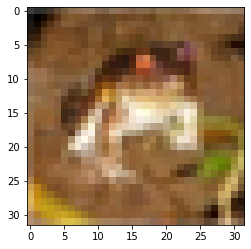

In [18]:
# 小栗子 看看数据
x, y = next(iter(train_ds))
print(idx2label.lookup(y))
plt.imshow(x)

我们在DataLoader中指明定义好的图像增广操作。在训练时，我们仅用验证集评价模型，因此需要保证输出的确定性。在预测时，我们将在训练集和验证集的并集上训练模型，以充分利用所有标注的数据。

In [0]:
train_iter = train_ds.map(transform_train)
valid_iter = valid_ds.map(transform_test)
train_valid_iter = train_valid_ds.map(transform_train)
test_iter = test_ds.map(transform_test)

In [0]:
batch_size = 8
train_iter = train_iter.shuffle(1024).batch(batch_size)
valid_iter = valid_iter.shuffle(1024).batch(batch_size)
train_valid_iter = train_valid_iter.shuffle(1024).batch(batch_size)
test_iter = test_iter.shuffle(1024).batch(batch_size)

tf.Tensor(b'ship', shape=(), dtype=string)


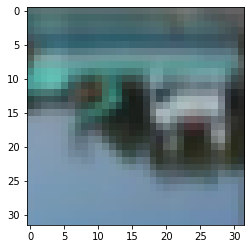

In [21]:
# 小栗子 看看数据
x, y = next(iter(train_iter))
print(idx2label.lookup(y[0]))
plt.imshow(x[0])

## 9.12.4. 定义模型

与“残差网络（ResNet）”一节中的实现稍有不同，这里基于HybridBlock类构建残差块。这是为了提升执行效率。

tensorflow 好像没有这种？ 还用原来那个定义好了

In [0]:
class Residual(keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(num_channels,
                        padding='same',
                        kernel_size=3,
                        strides=strides)
        self.conv2 = keras.layers.Conv2D(num_channels,
                        kernel_size=3,
                        padding='same')
        if use_1x1conv:
            self.conv3 = keras.layers.Conv2D(num_channels,
                            kernel_size=1,
                            strides=strides)
        else:
            self.conv3 = None
        self.bn1 = keras.layers.BatchNormalization()
        self.bn2 = keras.layers.BatchNormalization()
    
    def call(self, x):
        y = keras.activations.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        return keras.activations.relu(y + x)

下面定义ResNet-18模型。

In [0]:
def resnet18(num_classes):
    net = keras.Sequential()
    net.add(keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.Activation('relu'))

    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = keras.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk
    
    net.add(resnet_block(64, 2, first_block=True))
    net.add(resnet_block(128, 2))
    net.add(resnet_block(256, 2))
    net.add(resnet_block(512, 2))
    net.add(keras.layers.GlobalAveragePooling2D())
    net.add(keras.layers.Dense(num_classes, activation='softmax'))
    return net

CIFAR-10图像分类问题的类别个数为10。

In [0]:
def get_net():
    num_classes = 10
    net = resnet18(num_classes)
    return net
net = get_net()

In [25]:
x = tf.random.uniform(shape=(1,32,32,3))
for layer in net.layers:
    x = layer(x)
    print(layer.name, "output_shape:", x.shape)

conv2d output_shape: (1, 32, 32, 64)
batch_normalization output_shape: (1, 32, 32, 64)
activation output_shape: (1, 32, 32, 64)
sequential_1 output_shape: (1, 32, 32, 64)
sequential_2 output_shape: (1, 16, 16, 128)
sequential_3 output_shape: (1, 8, 8, 256)
sequential_4 output_shape: (1, 4, 4, 512)
global_average_pooling2d output_shape: (1, 512)
dense output_shape: (1, 10)


## 9.12.5. 定义训练函数

我们将根据模型在验证集上的表现来选择模型并调节超参数。下面定义了模型的训练函数train。我们记录了每个迭代周期的训练时间，这有助于比较不同模型的时间开销。

In [0]:
lr = 0.1
lr_decay = 0.01

def scheduler(epoch):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(lr_decay * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

net.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

## 9.12.6. 训练模型

现在，我们可以训练并验证模型了。简单起见，这里仅训练1个迭代周期。

In [27]:
net.fit(train_iter,
    epochs=1,
    validation_data=valid_iter,
    callbacks=[callback])

12/12 [==============================] - 9s 770ms/step - loss: 13.8743 - accuracy: 0.0556 - val_loss: 4652004352.0000 - val_accuracy: 0.1000 - lr: 0.1000


## 9.12.7. 对测试集分类并在Kaggle提交结果

得到一组满意的模型设计和超参数后，我们使用所有训练数据集（含验证集）重新训练模型，并对测试集进行分类。

In [28]:
net.compile(optimizer=keras.optimizers.SGD(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

net.fit(train_valid_iter,
    epochs=1,
    callbacks=[callback])

13/13 [==============================] - 9s 730ms/step - loss: 4.6589 - accuracy: 0.0700 - lr: 0.1000


执行完上述代码后，我们会得到一个submission.csv文件。这个文件符合Kaggle比赛要求的提交格式。提交结果的方法与“实战Kaggle比赛：房价预测”一节中的类似。